# Topic Modeling with LDA

This notebook performs automatic topic discovery on news articles using **Latent Dirichlet Allocation (LDA)**. 
It identifies hidden themes (e.g., Politics, Markets, Technology) and visualizes their distribution and evolution over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

# Setup
%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Load Data

In [9]:
try:
    df = pd.read_csv(r"C:\Users\abhis\OneDrive\Desktop\abhigit\Toeho-AI\fetch_data_with_chunking.csv")
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Drop rows with missing content or date
    df = df.dropna(subset=['content', 'date'])
    print(f"Loaded {len(df)} articles.")
    display(df.head(3))
except FileNotFoundError:
    print("Error: 'fetch_data_with_chunking.csv' not found. Please run the scraping notebook first.")

Loaded 15 articles.


,url,headline,category,date,content,sentiment_score,sentiment_label
0,https://www.thehindu.com/opinion/lead/the-righ...,The right to disconnect in an ‘always-on’ econ...,General,2026-01-06,"In the digital age, our greatest tools of prod...",0.096066,Positive
1,https://www.thehindu.com/sci-tech/science/nitr...,The perfect flaw: how a diamond defect is chan...,General,2026-01-07,Imagine a diamond.You probably thought of a cl...,0.115856,Positive
2,https://www.thehindu.com/opinion/columns/crick...,BCCI vs BCB: Cricket is collateral damage in a...,General,2026-01-06,For so long has the Board of Control for Crick...,0.008144,Neutral


## 2. Preprocessing
We clean the text by removing special characters and numbers to improve topic quality.

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special chars/numbers
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

## 3. LDA Topic Modeling
We extract **5 topics** from the text. You can adjust `n_components` to find more or fewer topics.

In [11]:
# Vectorize Content (Document-Term Matrix)
# max_df=0.9: ignore terms appearing in >90% of docs
# min_df=2: ignore terms appearing in <2 docs
# stop_words='english': remove common English words
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_content'])

# Train LDA Model
N_TOPICS = 5
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42)
lda.fit(dtm)

print("LDA Model Trained Successfully!")

LDA Model Trained Successfully!


## 4. Explore Topics
Let's look at the top words for each topic to label them.

In [12]:
def get_top_words_df(model, feature_names, n_top_words=10):
    topics_data = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics_data[f"Topic {topic_idx+1}"] = top_features
    return pd.DataFrame(topics_data)

top_words_df = get_top_words_df(lda, vectorizer.get_feature_names_out())
print("Top Words per Topic:")
display(top_words_df)

Top Words per Topic:


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,health,right,india,government,oil
1,police,working,cricket,hours,mr
2,india,hours,bangladesh,capital,trump
3,need,employees,world,act,president
4,place,centre,bcb,mr,venezuela
5,public,health,indian,police,american
6,mental,energy,critical,state,economic
7,incident,world,icc,minister,interim
8,alleged,mental,bjp,pradesh,said
9,new,light,said,said,government


## 5. Visualizations

### A. Assign Topics to Articles

In [13]:
# Get topic probability distribution for each document
topic_results = lda.transform(dtm)

# Assign dominant topic
df['Topic'] = topic_results.argmax(axis=1) + 1
display(df[['headline', 'Topic']].head())

,headline,Topic
0,The right to disconnect in an ‘always-on’ econ...,2
1,The perfect flaw: how a diamond defect is chan...,2
2,BCCI vs BCB: Cricket is collateral damage in a...,3
3,Where health stands as the year beginsPremium,1
4,"When eggs, stones were hurled at T.N. Governor...",4


### B. Topic Distribution Bar Chart

C:\Users\abhis\AppData\Local\Temp\ipykernel_42124\128568314.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Topic', palette='viridis')


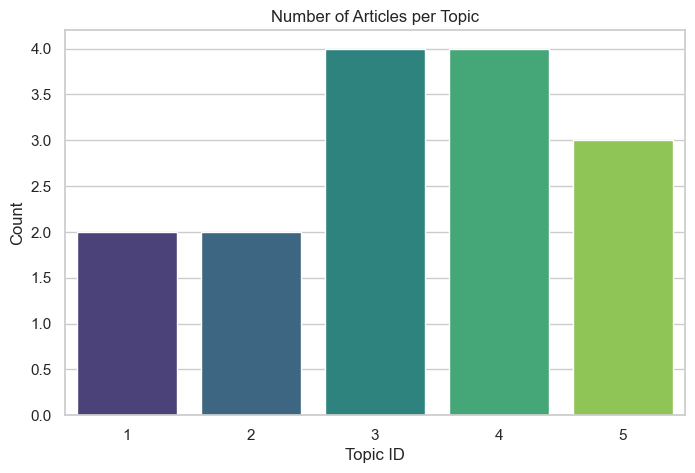

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Topic', palette='viridis')
plt.title('Number of Articles per Topic')
plt.ylabel('Count')
plt.xlabel('Topic ID')
plt.show()

### C. Topic Evolution Over Time

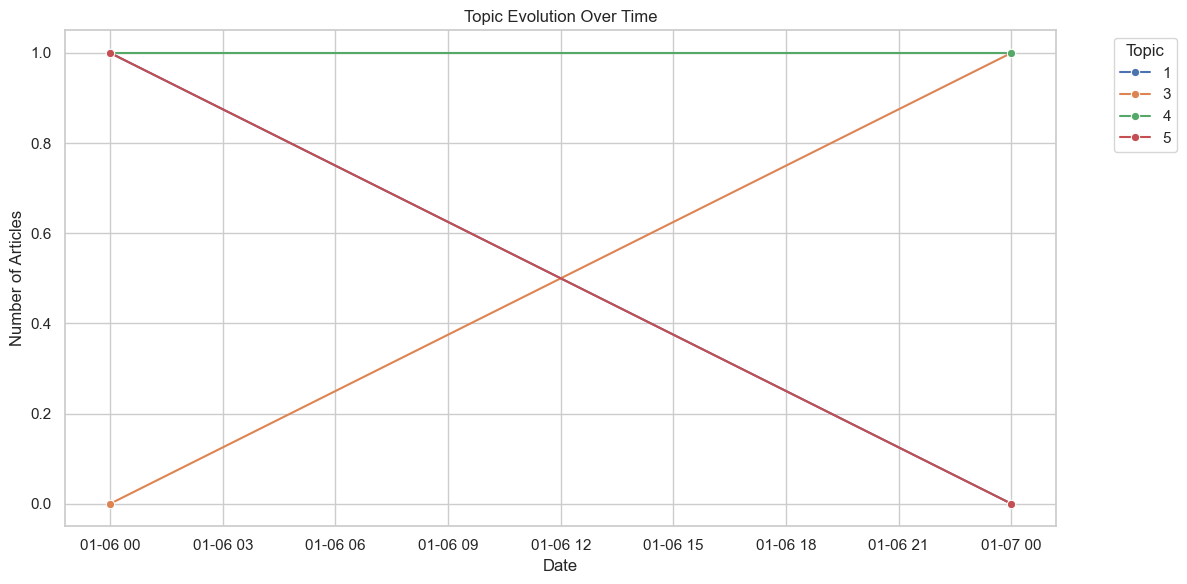

In [8]:
# Group by Date and Topic
topic_evolution = df.groupby([df['date'].dt.date, 'Topic']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=topic_evolution, dashes=False, marker='o')
plt.title('Topic Evolution Over Time')
plt.ylabel('Number of Articles')
plt.xlabel('Date')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()